In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Install Libraries and Modules

In [10]:
import warnings
warnings.filterwarnings('ignore') 

In [11]:
!pip uninstall -y wandb

Found existing installation: wandb 0.17.5
Uninstalling wandb-0.17.5:
  Successfully uninstalled wandb-0.17.5


In [12]:
!pip install wandb==0.17.5 

  Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
Using cached wandb-0.17.5-py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (6.8 MB)


In [13]:
import wandb

In [14]:
!wandb offline
!wandb disabled

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.
W&B disabled.


In [15]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [16]:
!pip install datasets transformers evaluate sentencepiece accelerate

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [18]:
import os

path = '/kaggle/input'
print(os.listdir(path))


['public_data_test']


In [21]:
train_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/train/afr.csv")
train_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/train/arq.csv")
train_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/train/hin.csv")
train_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/train/swe.csv")


dev_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/afr.csv")
dev_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/arq.csv")
dev_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/hin.csv")
dev_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/dev/swe.csv")


test_afr = pd.read_csv("/kaggle/input/public_data_test/track_a/test/afr.csv")
test_arq = pd.read_csv("/kaggle/input/public_data_test/track_a/test/arq.csv")
test_hin = pd.read_csv("/kaggle/input/public_data_test/track_a/test/hin.csv")
test_swe = pd.read_csv("/kaggle/input/public_data_test/track_a/test/swe.csv")

# AFRIKAANS

## Sources:
- https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

In [22]:
train_afr.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_train_track_a_00001,Die grondeienaars het die departement genader ...,0,0,0,0,0
1,afr_train_track_a_00002,Dit is verder 'n erkende feit dat daar menings...,0,0,0,0,0
2,afr_train_track_a_00003,Baie families in die Wes-Kaap is in rou gedomp...,0,0,0,0,1
3,afr_train_track_a_00004,Ons wil u deelmaak van die werk wat ons doen.,0,0,0,1,0
4,afr_train_track_a_00005,En dit onderstreep waarom NALN en NELM gesamen...,0,0,0,1,0


In [23]:
train_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222 entries, 0 to 1221
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1222 non-null   object
 1   text     1222 non-null   object
 2   anger    1222 non-null   int64 
 3   disgust  1222 non-null   int64 
 4   fear     1222 non-null   int64 
 5   joy      1222 non-null   int64 
 6   sadness  1222 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 67.0+ KB


In [24]:
dev_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98 non-null     object
 1   text     98 non-null     object
 2   anger    98 non-null     int64 
 3   disgust  98 non-null     int64 
 4   fear     98 non-null     int64 
 5   joy      98 non-null     int64 
 6   sadness  98 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 5.5+ KB


<Axes: >

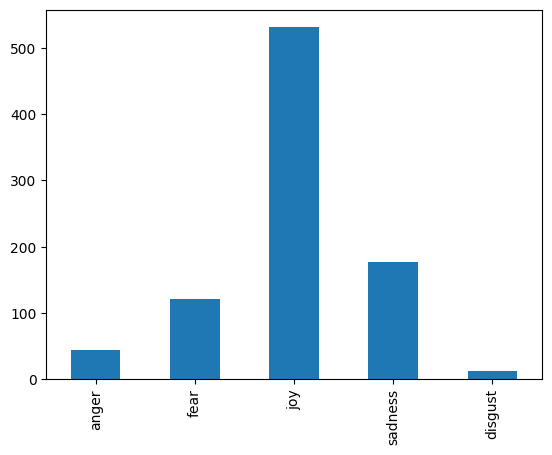

In [25]:
attributes = ['anger', 'fear', 'joy', 'sadness', 'disgust']
train_afr[attributes].sum().plot.bar()

<Axes: >

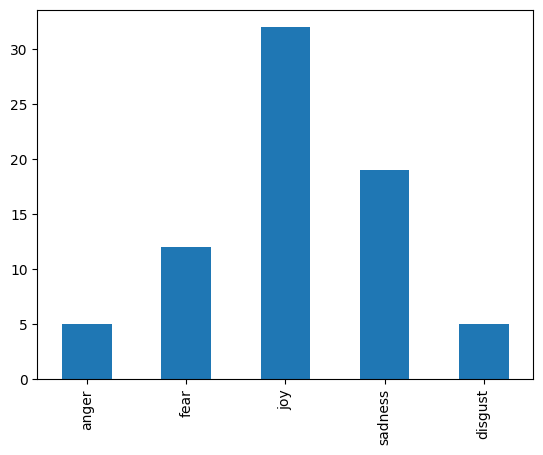

In [26]:
dev_afr[attributes].sum().plot.bar()

In [27]:
test_afr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1065 non-null   object 
 1   text     1065 non-null   object 
 2   anger    0 non-null      float64
 3   disgust  0 non-null      float64
 4   fear     0 non-null      float64
 5   joy      0 non-null      float64
 6   sadness  0 non-null      float64
dtypes: float64(5), object(2)
memory usage: 58.4+ KB


In [28]:
test_afr.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_test_track_a_00001,As regering is ons daartoe verbind om ons deel...,NaN,NaN,NaN,NaN,NaN
1,afr_test_track_a_00002,Op die oomblik is die kwessie van voedselsekur...,NaN,NaN,NaN,NaN,NaN
2,afr_test_track_a_00003,Ek hoor dikwels mense sê hulle is gereed om be...,NaN,NaN,NaN,NaN,NaN
3,afr_test_track_a_00004,Hiervan bly kindermishandeling waarskynlik een...,NaN,NaN,NaN,NaN,NaN
4,afr_test_track_a_00005,So gaan ons ernstig kyk na die kwaliteit van o...,NaN,NaN,NaN,NaN,NaN


https://huggingface.co/FacebookAI/xlm-roberta-base

In [29]:
emotion_labels = ["anger", "disgust", "fear", "joy", "sadness"]

In [30]:
from peft import get_peft_model, LoraConfig, TaskType
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  
    r=16, 
    lora_alpha=64,  
    lora_dropout=0.1,  
    bias="none"  
)


In [31]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-xlm-roberta-base-sentiment',
                                                           problem_type="multi_label_classification",
                                                           ignore_mismatched_sizes=True,
                                                           num_labels=len(emotion_labels))

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

trainable params: 1,184,261 || all params: 279,231,754 || trainable%: 0.4241
None


In [33]:
# Tokenizer function
# def tokenize(batch):
#     return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

def tokenize_with_emotions(batch):
    emotions = "anger, disgust, fear, joy, sadness, or surprise?"  # Concatenate all emotions
    return tokenizer(emotions, batch['text'], padding=True, truncation=True, max_length=128)


In [34]:
# Encode datasets
# def encode_data(df, tokenizer):
#     encodings = tokenizer(list(df['text']), truncation=True, padding=True, max_length=128)
#     labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness']].fillna(0).values
#     return encodings, labels

def encode_data_with_demux(df, tokenizer):
    emotions = ["anger", "disgust", "fear", "joy", "sadness"]
    text_with_emotions = [", ".join(emotions) + "?" + " " + t for t in df['text']]
    encodings = tokenizer(text_with_emotions, truncation=True, padding=True, max_length=128)
    labels = df[['anger', 'disgust', 'fear', 'joy', 'sadness']].fillna(0).values
    return encodings, labels

In [35]:
train_encodings, train_labels = encode_data_with_demux(train_afr, tokenizer)
dev_encodings, dev_labels = encode_data_with_demux(dev_afr, tokenizer)

In [36]:
# Custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [37]:
train_dataset = CustomDataset(train_encodings, train_labels)
dev_dataset = CustomDataset(dev_encodings, dev_labels)

In [38]:
train_dataset

In [39]:
def calculate_token_lengths(texts, tokenizer):
    token_lengths = [len(tokenizer.encode(text, truncation=False)) for text in texts]
    return token_lengths

# Calculate token lengths for your datasets
train_lengths = calculate_token_lengths(train_afr['text'], tokenizer)
dev_lengths = calculate_token_lengths(dev_afr['text'], tokenizer)
test_lengths = calculate_token_lengths(test_afr['text'], tokenizer)

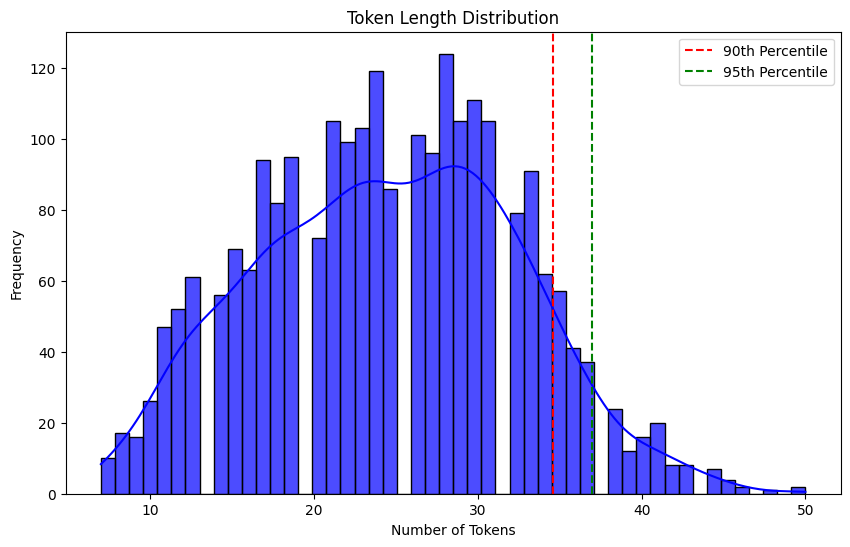

In [40]:
# Combine lengths from all datasets for a global view
all_lengths = train_lengths + dev_lengths + test_lengths

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_lengths, bins=50, kde=True, color='blue', alpha=0.7)
plt.axvline(x=np.percentile(all_lengths, 90), color='red', linestyle='--', label='90th Percentile')
plt.axvline(x=np.percentile(all_lengths, 95), color='green', linestyle='--', label='95th Percentile')
plt.title('Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [41]:
from transformers import EarlyStoppingCallback

In [42]:
correlation_matrix = torch.tensor([
    [1.0, 0.3, 0.5, -0.2, 0.1],  # anger
    [0.3, 1.0, 0.4, -0.1, 0.2],  # disgust
    [0.5, 0.4, 1.0, 0.2, 0.3],   # fear
    [-0.2, -0.1, 0.2, 1.0, -0.4], # joy
    [0.1, 0.2, 0.3, -0.4, 1.0]    # sadness
])


In [68]:
import torch
import torch.nn.functional as F

def combined_loss(outputs, labels, correlation_matrix, alpha=0.1, beta=0.2):
    """
    Computes the combined loss: BCE + local + global correlation-aware loss.

    Parameters:
    - outputs: logits from the model (pre-sigmoid).
    - labels: true labels (binary, one-hot encoded).
    - correlation_matrix: predefined correlation matrix.
    - alpha, beta: weights for the local and global loss terms.

    Returns:
    - Total loss.
    """
    # Sigmoid probabilities
    probs = torch.sigmoid(outputs)
    
    # Binary Cross-Entropy Loss (BCE)
    bce_loss = F.binary_cross_entropy_with_logits(outputs, labels, reduction='mean')

    # Global Loss (L_G)
    global_loss = 0
    for i in range(correlation_matrix.size(0)):
        for j in range(correlation_matrix.size(1)):
            if i != j:
                cosine_sim = torch.cosine_similarity(probs[:, i].unsqueeze(1), probs[:, j].unsqueeze(1), dim=0)
                global_loss += (cosine_sim - correlation_matrix[i, j]) ** 2
    global_loss /= (correlation_matrix.size(0) * correlation_matrix.size(1))

    # Local Loss (L_L)
    local_loss = 0
    for i in range(labels.size(1)):  # Iterate over all emotions
        for j in range(labels.size(1)):  # Compare emotions
            if i != j:
                positive_indices = (labels[:, i] == 1)  # Present emotion
                negative_indices = (labels[:, j] == 0)  # Absent emotion

                if positive_indices.sum() > 0 and negative_indices.sum() > 0:  # Avoid empty index errors
                    # Select the corresponding probabilities
                    positive_probs = probs[positive_indices, i].unsqueeze(1)  # Shape: [positive_samples, 1]
                    negative_probs = probs[negative_indices, j].unsqueeze(1)  # Shape: [negative_samples, 1]
                    
                    # Ensure both tensors have the same size for cosine similarity
                    min_size = min(positive_probs.size(0), negative_probs.size(0))
                    positive_probs = positive_probs[:min_size]
                    negative_probs = negative_probs[:min_size]
                    
                    # Compute cosine similarity
                    cosine_sim = torch.cosine_similarity(positive_probs, negative_probs, dim=0)
                    local_loss += cosine_sim ** 2

    # Normalize the local loss
    local_loss /= (labels.size(1) * labels.size(0) if labels.size(0) > 0 else 1)

    # Combine the losses
    total_loss = (1 - alpha) * bce_loss + alpha * local_loss 
    return total_loss


In [69]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False):
        """
        Custom loss function for the Hugging Face Trainer.
        """
        labels = inputs.pop("labels")  # Extract labels
        outputs = model(**inputs)      # Forward pass
        logits = outputs.logits        # Extract logits

        # Compute custom loss
        loss = combined_loss(logits, labels, correlation_matrix, alpha=0.5, beta=0.5)

        return (loss, outputs) if return_outputs else loss

In [70]:
# Metrics
def compute_metrics(pred, threshold=0.5):
    logits, labels = pred
    predictions = (torch.sigmoid(torch.tensor(logits)) > threshold).numpy()
    labels = labels.astype(int)

    # Per-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': np.mean(f1),
        'precision': np.mean(precision),
        'recall': np.mean(recall),
    }


In [71]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results/afr/xlm-roberta-sentiment-v1',
    report_to=None,
    evaluation_strategy="steps",
    save_total_limit = 1,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    metric_for_best_model="f1"
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [72]:
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  
    early_stopping_threshold=0.00001  
)

In [73]:
# Create trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

In [74]:
from unittest import mock
from unittest.mock import Mock
class Dummy:
    def __enter__(self):
        return Mock()

    def __exit__(self, *args):
        pass

In [75]:
with mock.patch('wandb.init', return_value=Dummy()):
    trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.174900,0.239671,0.489796,0.500537,0.456993,0.561644
1000,0.173300,0.229983,0.551020,0.533855,0.562772,0.547945
1500,0.164200,0.229181,0.551020,0.553906,0.567776,0.589041
2000,0.161300,0.227860,0.571429,0.561687,0.582518,0.589041
2500,0.160000,0.225011,0.581633,0.570831,0.595242,0.589041
3000,0.161500,0.223874,0.551020,0.553108,0.571191,0.575342
3500,0.152800,0.223560,0.571429,0.558099,0.582290,0.575342
4000,0.150600,0.223939,0.581633,0.564826,0.586301,0.589041


In [76]:
# Function to find the optimal threshold
def find_best_threshold(pred, thresholds):
    best_threshold = 0.5
    best_f1 = 0

    for t in thresholds:
        metrics = compute_metrics(pred, threshold=t)
        print(f"metrics: {metrics}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_threshold = t

    return best_threshold, best_f1

In [77]:
# Validation step
def evaluate_on_validation_set(trainer, threshold_range=np.linspace(0.1, 0.9, 9)):
    # Run predictions on the validation set
    predictions, labels, _ = trainer.predict(dev_dataset)  # Ensure dev_dataset is defined
    pred = (predictions, labels)

    # Find the best threshold
    best_threshold, best_f1 = find_best_threshold(pred, thresholds=threshold_range)
    print("----------------------------------------------")
    print(f"Best Threshold: {best_threshold}, Best F1-Score: {best_f1:.4f}")
    print("***********************************************")
    # Evaluate using the best threshold
    final_metrics = compute_metrics(pred, threshold=best_threshold)
    print(f"Metrics with Best Threshold: {final_metrics}")

    return best_threshold, final_metrics

In [78]:
best_threshold, final_metrics = evaluate_on_validation_set(trainer)
print(f"Optimal Threshold: {best_threshold}")
print(f"Final Metrics: {final_metrics}")

metrics: {'accuracy': 0.3673469387755102, 'f1': 0.5398934550989346, 'precision': 0.4108561328545212, 'recall': 0.821917808219178}
metrics: {'accuracy': 0.42857142857142855, 'f1': 0.5699460356994605, 'precision': 0.5117547292889759, 'recall': 0.7397260273972602}
metrics: {'accuracy': 0.46938775510204084, 'f1': 0.5315656616103542, 'precision': 0.4737739162448719, 'recall': 0.6301369863013698}
metrics: {'accuracy': 0.5306122448979592, 'f1': 0.541183919251465, 'precision': 0.5409755630270163, 'recall': 0.589041095890411}
metrics: {'accuracy': 0.5816326530612245, 'f1': 0.5708309954885298, 'precision': 0.5952415284787311, 'recall': 0.589041095890411}
metrics: {'accuracy': 0.6326530612244898, 'f1': 0.5297713981924509, 'precision': 0.5482905490963509, 'recall': 0.5205479452054794}
metrics: {'accuracy': 0.6122448979591837, 'f1': 0.45820830615351166, 'precision': 0.5260545905707197, 'recall': 0.4246575342465753}
metrics: {'accuracy': 0.5612244897959183, 'f1': 0.3706156856841789, 'precision': 0.5

In [79]:
# Evaluate on dev set
dev_results = trainer.predict(dev_dataset)

# Plot confusion matrix
predictions = (torch.sigmoid(torch.tensor(dev_results.predictions)) > 0.1).numpy()
conf_matrix = confusion_matrix(dev_labels.ravel(), predictions.ravel())

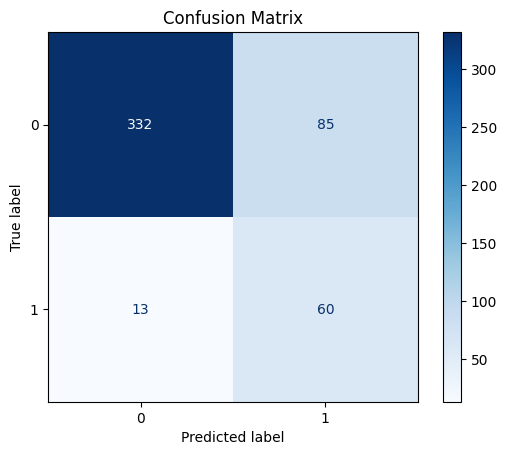

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

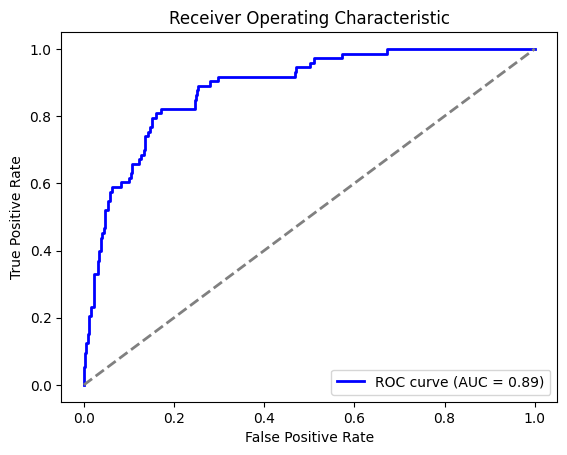

In [81]:
# ROC curve and AUC
fpr, tpr, _ = roc_curve(dev_labels.ravel(), dev_results.predictions.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [82]:
# Print metrics for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    dev_labels, predictions, average=None
)
accuracy = accuracy_score(dev_labels, predictions)

print(f'Accuracy: {accuracy:.4f}')
for i, label in enumerate(['anger', 'disgust', 'fear', 'joy', 'sadness']):
    print(f"{label}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

Accuracy: 0.3673
anger: Precision=0.3077, Recall=0.8000, F1=0.4444
disgust: Precision=0.3333, Recall=0.2000, F1=0.2500
fear: Precision=0.3929, Recall=0.9167, F1=0.5500
joy: Precision=0.4559, Recall=0.9688, F1=0.6200
sadness: Precision=0.3939, Recall=0.6842, F1=0.5000


In [86]:
import numpy as np
import torch

# Tokenize the test data
test_encodings = tokenizer(list(test_afr['text']), truncation=True, padding=True, max_length=128, return_tensors="pt")
test_dataset = CustomDataset(test_encodings, np.zeros((len(test_afr), 5)))  # Dummy labels for test

# Predict using the trainer
test_results = trainer.predict(test_dataset)

# Apply sigmoid and thresholding to get predictions
test_predictions = (torch.sigmoid(torch.tensor(test_results.predictions)) > 0.5).numpy()

# Convert boolean predictions to 0 and 1
test_predictions = test_predictions.astype(int)

test_afr[['anger', 'disgust', 'fear', 'joy', 'sadness']] = test_predictions
test_afr.to_csv('test_predictions_afr_xlm_roberta_sentiment_v1_customloss.csv', index=False)